# ICU-Covid Prediction in Malaysia  
## Introduction  

### Objective  
The objective of this project is to **predict next week’s daily ICU Covid occupancy in Malaysia** using supervised learning models.  

This regression problem will be approached using **three supervised learning methods**:  
1. Linear Regression  
2. K-Nearest Neighbors (KNN) Regressor  
3. Decision Tree Regressor  

### Motivation  
- Predicting ICU Covid 7 days ahead helps healthcare authorities prepare capacity and resources.  
- Accurate predictions can inform **ICU readiness, ventilator allocation, and staff planning**.  
- By comparing different machine learning models, we aim to evaluate which method balances **prediction accuracy and computational efficiency**.  

### Dataset  
Source: [Ministry of Health Malaysia (MoH) GitHub Repository](https://github.com/MoH-Malaysia/covid19-public)  

We will use **country-level daily data**:  
- ICU Covid utilization (`icu_covid`)  
- Daily cases and testing  
- Hospital utilization  
- Vaccination progress  

We will use a **6-month consecutive date range**, starting from `START_DATE`.  
- End date will be computed automatically as **6 months after start**.  
- This ensures enough samples for training and testing while remaining focused on a meaningful period.  

### Methodology Overview  
The notebook will follow these steps:  
1. **Data Collection & Cleaning** – Load datasets and preprocess  
2. **Feature Engineering** – Transform and scale features for modeling  
3. **Dataset Splitting** – Train, validation, and test sets  
4. **Model Training, Tuning & Evaluation** – Train, tune and evaluate Linear Regression, KNN Regressor, and Decision Tree Regressor  
5. **Analysis & Conclusion** – Compare model performance and summarize findings  


In [269]:
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# --- Set constants ---
START_DATE = pd.to_datetime("2022-04-01")
END_DATE = START_DATE + pd.DateOffset(months=6) - pd.Timedelta(days=1)

# Target variable
TARGET = "icu_covid"


# Part 1: Data Collection & Cleaning

### Data Source
We will use official Malaysian Covid-19 datasets provided by the **Ministry of Health Malaysia (MoH)**, available on GitHub:  
[https://github.com/MoH-Malaysia/covid19-public](https://github.com/MoH-Malaysia/covid19-public)

### Selected Files
For this project, we will mainly use:
1. `cases_malaysia.csv` → Daily Covid-19 cases  
2. `tests_malaysia.csv` → Daily testing numbers  
3. `hospital.csv` → Hospitalization data  
4. `icu.csv` → ICU utilization data (contains our target variable)  
5. `vax_malaysia.csv` → Vaccination progress  

### Target Variable
- Our target variable for regression is `icu_covid`, i.e., the **number of Covid-19 patients in ICU per day**.


In [270]:
# --- Read the CSV files ---
datasets = {
    "cases": pd.read_csv("cases_malaysia.csv"),
    "tests": pd.read_csv("tests_malaysia.csv"),
    "hospital": pd.read_csv("hospital.csv"),
    "icu": pd.read_csv("icu.csv"),
    "vax": pd.read_csv("vax_malaysia.csv"),
}

# --- Data Cleaning ---
for name, df_temp in datasets.items():
    # Convert date column to datetime
    df_temp["date"] = pd.to_datetime(df_temp["date"])
    
    # Filter to 6-month range
    df_temp = df_temp[(df_temp["date"] >= START_DATE) & (df_temp["date"] <= END_DATE)].copy()
    
    # Drop unnecessary cluster columns in cases dataset
    if name == "cases":
        cluster_cols = [
            "cluster_import", "cluster_religious", "cluster_community",
            "cluster_highRisk", "cluster_education", "cluster_detentionCentre",
            "cluster_workplace"
        ]
        df_temp.drop(columns=cluster_cols, inplace=True, errors="ignore")
    
    # Aggregate numeric columns by date
    df_temp = df_temp.groupby("date").sum(numeric_only=True).reset_index()
    
    # Drop columns with a single unique value
    nunique = df_temp.nunique()
    cols_to_drop = nunique[nunique <= 1].index
    df_temp.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    
    # Fill missing values with 0
    df_temp.fillna(0, inplace=True)
    
    # Save cleaned dataset
    datasets[name] = df_temp

# --- Merge all datasets on date ---
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on="date", how="left"), datasets.values())

# --- Sort by date ---
df = df.sort_values("date").reset_index(drop=True)

# --- Display cleaned dataset ---
df


,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,sinopharm2,sinopharm3,sinopharm4,cansino,cansino3,cansino4,pending1,pending2,pending3,pending4
0,2022-04-01,17476,164,17321,206987,78,2671,801,3167,10837,...,7,44,0,199,16,0,1,1,1,0
1,2022-04-02,14692,218,20383,201240,36,2101,658,2653,9280,...,12,4,0,38,73,0,1,0,1,0
2,2022-04-03,12380,462,20635,192955,8,1854,559,2314,7653,...,6,10,0,23,1,0,3,0,1,0
3,2022-04-04,10002,98,23302,179627,2,1479,463,1973,6087,...,10,5,0,5,8,0,1,1,3,0
4,2022-04-05,12017,59,20431,171180,15,1799,550,2160,7508,...,4,5,0,32,32,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2022-09-26,1186,1,1690,24028,1,153,5,266,762,...,0,0,0,0,0,0,0,0,0,0
179,2022-09-27,1552,5,1684,23890,0,195,6,322,1029,...,1,0,0,13,0,0,0,0,0,0
180,2022-09-28,2445,2,1613,24720,0,185,16,484,1760,...,0,2,0,211,0,0,0,0,0,0
181,2022-09-29,1867,4,1402,25181,14,191,9,372,1295,...,2,0,0,0,0,0,0,0,0,0


# Part 2: Feature Engineering

We organize feature engineering into four subparts:

1. **Feature Selection** – select relevant numerical metrics and drop redundant or noisy columns.  
2. **Feature Transformation** – scale features and handle skewed distributions to improve model performance.  
3. **Lag Range Analysis** – compute correlations between lagged features (1–30 days) and the target to determine the optimal lag window.  
4. **Feature Creation (Lagging)** – create lag features from the chosen range to predict next week's cases.  


### Part 2.1: Feature Selection

**Objective:** Keep only predictive, non-redundant numerical features to improve generalization.  

**Reasoning:**  
- Drop columns that duplicate information or add unnecessary detail:  
  - **Case breakdowns** (e.g., age, vaccination type) → strongly correlated with total new cases  
  - **ICU/ventilator subcategories** → already captured by aggregate ICU/hospital metrics  
  - **Vaccination subgroups** → redundant with total vaccinations  
  - **Date column** → removed to avoid temporal leakage  
- This keeps the dataset compact and focused on the strongest predictors of future Covid-19 cases.  


In [271]:
# --- Feature Selection ---

features_to_drop = [
    # Date
    "date",
    
    # Case breakdowns
    "cases_import", "cases_recovered", "cases_cluster", "cases_pvax", "cases_fvax",
    "cases_child", "cases_adolescent", "cases_adult", "cases_elderly",
    "cases_0_4", "cases_5_11", "cases_12_17", "cases_18_29", "cases_30_39",
    "cases_40_49", "cases_50_59", "cases_60_69", "cases_70_79", "cases_80",
    
    # Hospital / ICU subcategories
    "admitted_pui", "admitted_covid", "admitted_total", "discharged_pui", "discharged_covid", 
    "discharged_total", "hosp_covid", "hosp_pui", "hosp_noncovid", "beds_icu_rep", 
    "beds_icu_total", "beds_icu_covid", "icu_pui", "icu_noncovid", "vent_covid", 
    "vent_pui", "vent_noncovid", "vent_used", "vent_port_used",
    
    # Vaccination subgroups
    "daily_partial_adol", "daily_full_adol", "daily_partial_child", "daily_full_child",
    "cumul_partial_adol", "cumul_full_adol", "cumul_partial_child", "cumul_full_child",
    "pfizer1", "pfizer2", "pfizer3", "sinovac1", "sinovac2", "sinovac3", "astra1", 
    "astra2", "sinopharm1", "sinopharm2", "cansino", "pending1", "pending2", "pending3"
]

# Select relevant features
features = df.drop(columns=features_to_drop, errors="ignore")

print("Shape after feature selection:", features.shape)
print("Selected features for modeling:")
print(features.columns.tolist())

Shape after feature selection: (183, 40)
Selected features for modeling:
['cases_new', 'cases_active', 'cases_unvax', 'cases_boost', 'rtk-ag', 'pcr', 'beds', 'beds_covid', 'beds_noncrit', 'beds_icu', 'vent', 'vent_port', 'icu_covid', 'daily_partial', 'daily_full', 'daily_booster', 'daily_booster2', 'daily', 'daily_booster_adol', 'daily_booster2_adol', 'daily_booster_child', 'daily_booster2_child', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul_booster2', 'cumul', 'cumul_booster_adol', 'cumul_booster2_adol', 'cumul_booster_child', 'cumul_booster2_child', 'pfizer4', 'sinovac4', 'astra3', 'astra4', 'sinopharm3', 'sinopharm4', 'cansino3', 'cansino4', 'pending4']


### Part 2.2: Feature Transformation

**Objective:** Transform features to improve model stability and fairness.  

1. **Scaling:** Use `RobustScaler` to reduce the influence of outliers while keeping features comparable for distance-based models (KNN) and regression.  
2. **Handling skewed distributions:** Apply log transformation to right-skewed features to limit the impact of extreme values.  

**Reasoning:**  
- Scaling ensures no single feature dominates due to magnitude differences.  
- Log transformation reduces skew, stabilizes variance, and improves predictive power.  


In [272]:
# --- Log-transform to reduce skewness ---
log_transformer = FunctionTransformer(np.log1p, np.expm1, validate=False)
X_log = log_transformer.fit_transform(features)

# --- Robust scaling ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

# --- Update features for modeling ---
X = pd.DataFrame(X_scaled, columns=features.columns, index=features.index)

print("Feature matrix shape after transformations:", X.shape)
print("Data types after transformation:\n", X.dtypes.value_counts())


Feature matrix shape after transformations: (183, 40)
Data types after transformation:
 float64    40
Name: count, dtype: int64


### Part 2.3: Lag Range Analysis

**Objective:** Identify the most predictive lag window for feature creation.  

**Approach:**  
1. Generate lagged versions of the target variable (`cases_new`) for 7–31 days.  
2. Compute the correlation of each lag with the current target.  
3. Select the lag range where correlation is strongest and most consistent.  

**Reasoning:**  
- Covid-19 case trends often follow temporal patterns, where past values influence future outcomes.  
- Using an empirically determined lag window avoids arbitrary choices (e.g., always 7–14 days).  
- This ensures created lag features capture the most relevant temporal dependencies.  


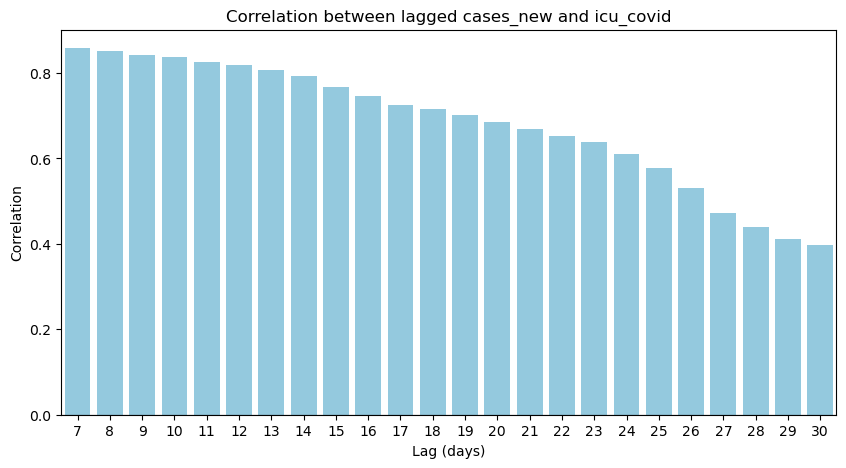

Best 7-day lag window: (7, 13) (avg |correlation| = 0.834)
Lags selected: [7, 8, 9, 10, 11, 12, 13]


In [273]:
### Part 2.3: Lag Range Analysis

# --- Parameters ---
TARGET = "icu_covid"
BASE_FEATURE = "cases_new"
test_range_start = 7
test_range_end = 31
window_size = 7

# --- Compute correlations ---
lag_corr = {}
for lag in range(test_range_start, test_range_end):
    lagged = df[BASE_FEATURE].shift(lag)
    corr = df[TARGET].corr(lagged)
    lag_corr[lag] = corr

# --- Convert to DataFrame ---
lag_corr_df = pd.DataFrame.from_dict(lag_corr, orient="index", columns=["correlation"])
lag_corr_df.index.name = "lag_days"

# --- Plot correlations ---
plt.figure(figsize=(10, 5))
sns.barplot(x=lag_corr_df.index, y=lag_corr_df["correlation"], color="skyblue")
plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"Correlation between lagged {BASE_FEATURE} and {TARGET}")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.show()

# --- Find best 7-day lag window ---
best_avg = -np.inf
best_range = (None, None)

for start in range(test_range_start, test_range_end - window_size + 1):
    end = start + window_size - 1
    avg_corr = lag_corr_df.loc[start:end, "correlation"].abs().mean()
    if avg_corr > best_avg:
        best_avg = avg_corr
        best_range = (start, end)

selected_lags = list(range(best_range[0], best_range[1] + 1))

print(f"Best 7-day lag window: {best_range} (avg |correlation| = {best_avg:.3f})")
print(f"Lags selected: {selected_lags}")


### Part 2.4: Feature Visualization

**Objective:** Visualize feature distributions to evaluate the impact of **selection, transformation, and lagging**.  

**Reasoning:**  
1. Compare raw vs. transformed features to confirm reduced skewness and consistent scaling.  
2. Inspect lagged features to ensure temporal patterns are preserved.  
3. Detect outliers or anomalies that may require additional preprocessing.  


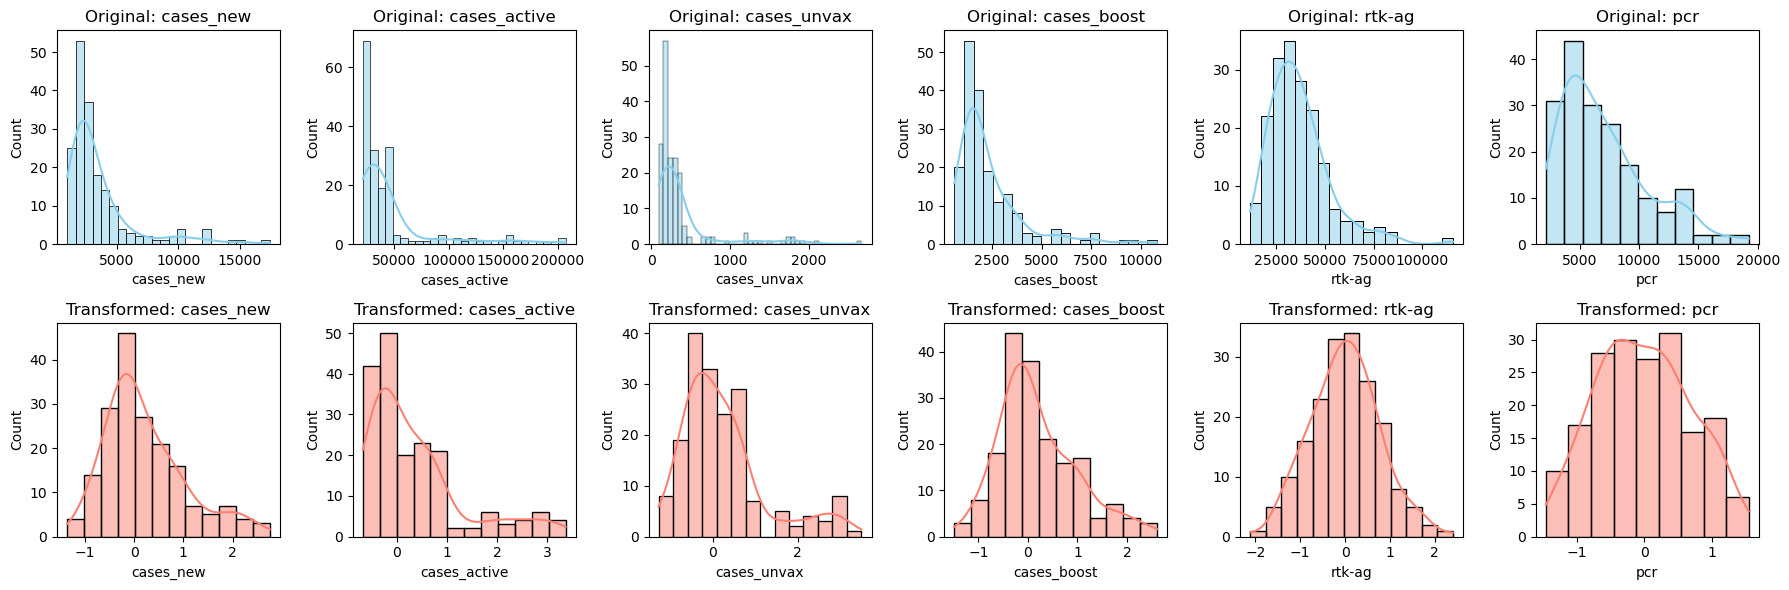

In [274]:
# --- Feature Visualization ---

# Original features before selection
original_features = df.drop(columns=['date'], errors="ignore")

# Features after selection and transformations (Part 2.1 & 2.2)
processed_features = X.copy()

# Pick common columns to compare
common_cols = [col for col in processed_features.columns if col in original_features.columns]
num_features_to_plot = min(6, len(common_cols))  # limit for clarity
sample_cols = common_cols[:num_features_to_plot]

plt.figure(figsize=(18, 6))

for i, col in enumerate(sample_cols, 1):
    # Original distribution
    plt.subplot(2, num_features_to_plot, i)
    sns.histplot(original_features[col], kde=True, color='skyblue')
    plt.title(f'Original: {col}')
    
    # Transformed distribution
    plt.subplot(2, num_features_to_plot, i + num_features_to_plot)
    sns.histplot(processed_features[col], kde=True, color='salmon')
    plt.title(f'Transformed: {col}')

plt.tight_layout()
plt.show()


### Part 2.4: Feature Creation (Lagging)

**Objective:** Create lag features based on the **best lag window** identified in Part 2.3 to predict **ICU_Covid one week ahead**.

**Reasoning:**  
1. The lag window is determined empirically by maximizing correlation with the target, ensuring the model leverages the most predictive historical signals.  
2. The target (`icu_covid`) is shifted 7 days forward to align with the **one-week-ahead prediction goal**.  
3. Dynamic lag features enable models (KNN, Linear Regression, Decision Trees) to capture **temporal dependencies** without arbitrary assumptions.  


In [275]:
# --- Create lagged features based on best lag window from Part 2.3 ---
lag_data = {}
start_lag, end_lag = best_range  # from lag range analysis

for col in X.columns:
    for lag in range(start_lag, end_lag + 1):
        lag_data[f"{col}_lag{lag}"] = X[col].shift(lag)

# Convert to DataFrame
lagged_features = pd.DataFrame(lag_data)
lagged_features["date"] = df["date"]

# Shift target (e.g., icu_covid) backward by 7 days for one-week-ahead prediction
y = df[TARGET].shift(-7)

# Combine lagged features with target
df_weekly = pd.concat([lagged_features, y.rename(f"{TARGET}_next_week")], axis=1)

# Drop rows with NaNs created by shifting
df_weekly = df_weekly.dropna().reset_index(drop=True)

# Final dataset for modeling
X_final = df_weekly.drop(columns=["date", f"{TARGET}_next_week"])
y_final = df_weekly[f"{TARGET}_next_week"]

print("Feature matrix shape:", X_final.shape)
print("Target vector shape:", y_final.shape)
print("Selected lag window:", best_range)


Feature matrix shape: (163, 280)
Target vector shape: (163,)
Selected lag window: (7, 13)


## Part 3: Splitting the Dataset

**Objective:**  
Divide the processed dataset into **training**, **validation**, and **testing sets** for model training, tuning, and evaluation.  

**Reasoning:**  
1. Since the dataset is **time-series**, random shuffling is avoided to prevent data leakage.  
2. A **chronological split** is applied:  
   - **Training set:** First 60% → model learns patterns.  
   - **Validation set:** Next 20% → hyperparameter tuning for Linear Regression, KNN, and Decision Tree.  
   - **Testing set:** Final 20% → evaluation on unseen data.  
3. This setup mimics real-world forecasting, where predictions rely only on **past observations**.  


Train shape: (97, 280) (97,)
Validation shape: (32, 280) (32,)
Test shape: (34, 280) (34,)


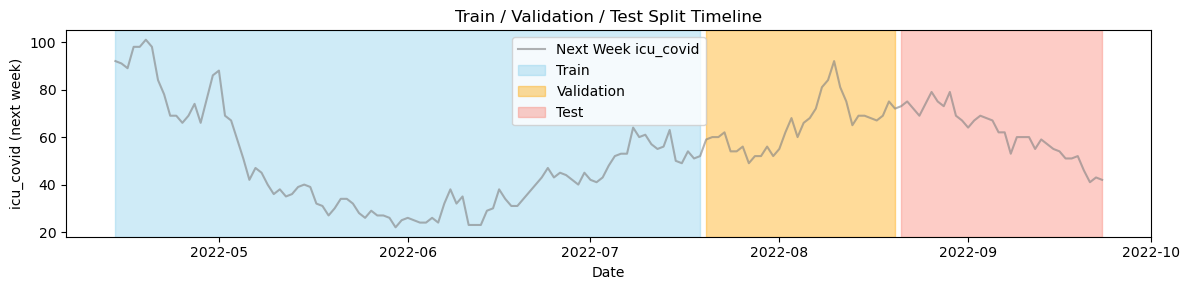

In [276]:
# --- Keep the date column for visualization ---
dates = df_weekly["date"]

# --- Chronological split ---
n = len(X_final)
train_size = int(0.6 * n)
val_size = int(0.2 * n)

# Training set (first 60%)
X_train = X_final.iloc[:train_size]
y_train = y_final.iloc[:train_size]
dates_train = dates.iloc[:train_size]

# Validation set (next 20%)
X_val = X_final.iloc[train_size:train_size + val_size]
y_val = y_final.iloc[train_size:train_size + val_size]
dates_val = dates.iloc[train_size:train_size + val_size]

# Testing set (final 20%)
X_test = X_final.iloc[train_size + val_size:]
y_test = y_final.iloc[train_size + val_size:]
dates_test = dates.iloc[train_size + val_size:]

# --- Print shapes ---
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# --- Visualization of splits ---
plt.figure(figsize=(12, 3))
plt.plot(dates, y_final, label=f"Next Week {TARGET}", color="gray", alpha=0.6)

plt.axvspan(dates_train.min(), dates_train.max(), color="skyblue", alpha=0.4, label="Train")
plt.axvspan(dates_val.min(), dates_val.max(), color="orange", alpha=0.4, label="Validation")
plt.axvspan(dates_test.min(), dates_test.max(), color="salmon", alpha=0.4, label="Test")

plt.title("Train / Validation / Test Split Timeline")
plt.xlabel("Date")
plt.ylabel(f"{TARGET} (next week)")
plt.legend()
plt.tight_layout()
plt.show()


## Part 4: Model Training, Tuning & Evaluation

**Objective:**  
Train, tune, and evaluate regression models to **predict ICU_Covid one week ahead** using lagged features. This section combines **model training**, **hyperparameter tuning**, and **evaluation** for all models.

### Supervised Learning Methods & Hyperparameters

We will use the following regression methods with appropriate regularization:

1. **Linear Regression (Ordinary Least Squares & Regularized Variants)**  
   - Hyperparameters to tune:
     1. `regularization` → None, Ridge (L2), Lasso (L1), ElasticNet  
     2. `alpha` → Regularization strength (for Ridge/Lasso/ElasticNet)  
     3. `l1_ratio` → Balance between L1 and L2 (for ElasticNet)  
     4. `fit_intercept` → Include or exclude intercept  
     5. `positive` → Restrict coefficients to be positive (False recommended for high-dimensional lag features)  
     6. `max_iter` → Maximum iterations for convergence (for Lasso/ElasticNet)

2. **K-Nearest Neighbors (KNN) Regression**  
   - Hyperparameters to tune:
     1. `n_neighbors` → Number of neighbors  
     2. `weights` → Uniform or distance-based weighting  
     3. `metric` → Distance metric (e.g., Euclidean, Manhattan)  
     4. `p` → Power parameter for Minkowski metric  

3. **Decision Tree Regression**  
   - Hyperparameters to tune:
     1. `max_depth` → Maximum depth of the tree  
     2. `min_samples_split` → Minimum samples required to split a node  
     3. `min_samples_leaf` → Minimum samples required for a leaf node  
     4. `max_features` → Maximum features considered for splits  

**Notes:**  
- Features are **lagged, log-transformed, and standardized** for numerical stability and improved model convergence.  
- Chronological splits prevent **data leakage**, ensuring future ICU data is not used in training.  
- Regularization helps prevent overfitting given the high-dimensional lag feature space.

### Evaluation Metrics

Each model will be assessed on the **validation and test sets** using:

1. **Mean Squared Error (MSE)** – Average squared difference between predicted and actual ICU cases  
2. **Root Mean Squared Error (RMSE)** – Square root of MSE, interpretable in the same units as ICU cases  
3. **Mean Absolute Error (MAE)** – Average absolute difference between predictions and true values  
4. **R² Score** – Proportion of variance explained by the model; indicates goodness of fit  
5. **Training Time** – Duration of model training to compare computational efficiency

### Visualization Plan

To understand model performance and behavior:

1. **Predicted vs Actual Plot** – Compare predicted ICU cases one week ahead against actual numbers  
2. **Residual Plot** – Show distribution of prediction errors to detect bias or heteroscedasticity  
3. **Training vs Validation Curve** – Assess underfitting/overfitting across hyperparameter choices  
4. **Comparison Bar Plot** – Summarize RMSE, MAE, R², and training time for all models for quick comparison


In [277]:
# --- Train a model and measure training time ---
def train_model(model, X_train, y_train):
    """
    Fit a model on the training data and return training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    return end_time - start_time

# --- Compute regression evaluation metrics ---
def evaluate_model(model, X, y_true):
    """
    Evaluate a trained regression model and return a dictionary of metrics.
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }
    return metrics, y_pred

# --- Plot Predicted vs Actual ---
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=y_true, y=y_pred, color="teal", alpha=0.7)
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Plot Residuals ---
def plot_residuals(y_true, y_pred, title="Residual Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=y_pred, y=residuals, color="orange", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Run full regression pipeline ---
def run_full_regression_pipeline(
    model,
    param_grid,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    cv=3,
    scoring="neg_mean_squared_error",
    model_name="Model"
):
    """
    Train, tune, evaluate on training, validation, and test sets, and produce plots.
    
    Returns:
    - best_model: trained best estimator
    - metrics_train: evaluation metrics on training set
    - metrics_val: evaluation metrics on validation set
    - metrics_test: evaluation metrics on test set
    - train_time: training duration
    """
    print(f"=== {model_name} ===")
    
    # 1. Hyperparameter tuning & training
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    train_time = train_model(grid, X_train, y_train)
    best_model = grid.best_estimator_
    
    print("Best Parameters:", grid.best_params_)
    print(f"Training Time: {train_time:.2f} seconds")
    
    # 2. Evaluate on training set
    metrics_train, y_train_pred = evaluate_model(best_model, X_train, y_train)
    print("Training Metrics:", metrics_train)
    
    # 3. Evaluate on validation set
    metrics_val, y_val_pred = evaluate_model(best_model, X_val, y_val)
    print("Validation Metrics:", metrics_val)
    
    # 4. Evaluate on test set
    metrics_test, y_test_pred = evaluate_model(best_model, X_test, y_test)
    print("Test Metrics:", metrics_test)
    
    # 5. Visualizations
    plot_predicted_vs_actual(y_test, y_test_pred, title=f"{model_name} Test: Predicted vs Actual")
    plot_residuals(y_test, y_test_pred, title=f"{model_name} Test: Residuals")
    
    return best_model, metrics_train, metrics_val, metrics_test, train_time

# --- Example dictionary to store results ---
all_results = {}


### 4.1 Linear Regressions

=== Linear Regression ===
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'fit_intercept': True, 'positive': False}
Training Time: 0.03 seconds
Training Metrics: {'MSE': 2.1295666102840542e-27, 'RMSE': 4.614722754710248e-14, 'MAE': 3.552713678800501e-14, 'R2': 1.0}
Validation Metrics: {'MSE': 146.34454835113036, 'RMSE': 12.097295084072735, 'MAE': 9.854956506091956, 'R2': -0.38735759064913977}
Test Metrics: {'MSE': 304.669026196262, 'RMSE': 17.454770872064234, 'MAE': 14.791694803585997, 'R2': -1.7606652788737698}


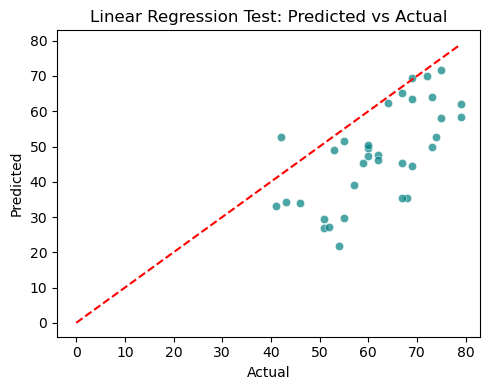

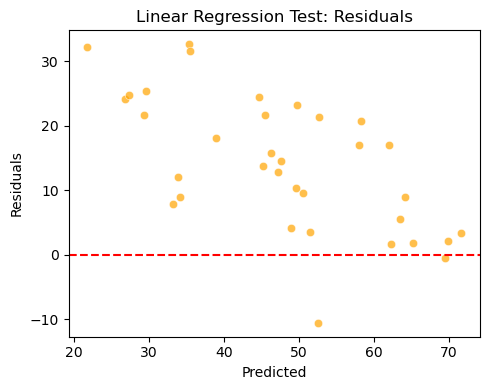

=== Ridge Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'alpha': 10, 'fit_intercept': True, 'positive': False}
Training Time: 0.13 seconds
Training Metrics: {'MSE': 15.43680914279458, 'RMSE': 3.9289704940091594, 'MAE': 2.7918492867278926, 'R2': 0.9637135856013102}
Validation Metrics: {'MSE': 106.65872868307534, 'RMSE': 10.32757128675834, 'MAE': 8.781978720881217, 'R2': -0.011132963370881654}
Test Metrics: {'MSE': 142.45773518796796, 'RMSE': 11.935565976859579, 'MAE': 10.473528190662487, 'R2': -0.29083723459001987}


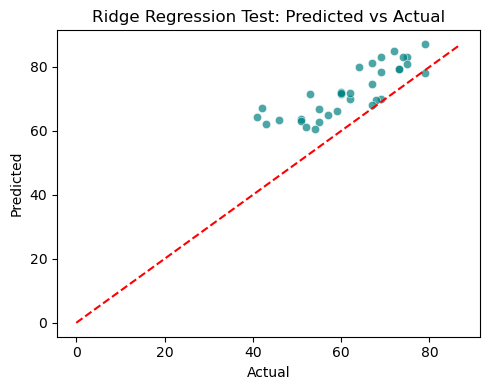

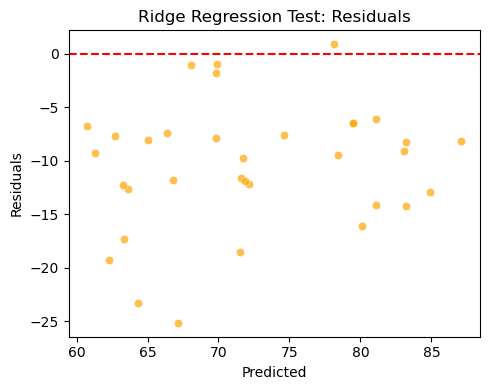

=== Lasso Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'alpha': 1, 'fit_intercept': True, 'max_iter': 50000, 'positive': False}
Training Time: 0.74 seconds
Training Metrics: {'MSE': 50.73799170027551, 'RMSE': 7.123060557111353, 'MAE': 5.6673581721306245, 'R2': 0.880733137556938}
Validation Metrics: {'MSE': 113.58784770752102, 'RMSE': 10.657759976070066, 'MAE': 8.552666035676268, 'R2': -0.07682154544235598}
Test Metrics: {'MSE': 131.24066165708297, 'RMSE': 11.456031671442034, 'MAE': 10.315977397256143, 'R2': -0.18919715054898534}


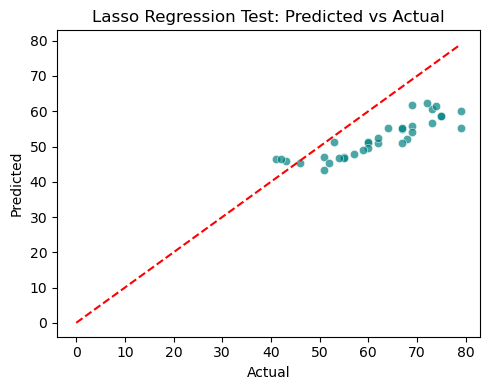

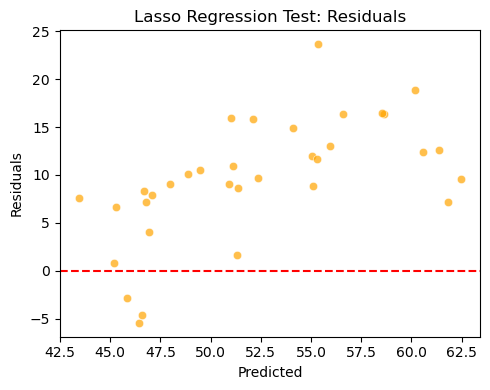

=== ElasticNet Regression ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'alpha': 10, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 50000, 'positive': False}
Training Time: 3.36 seconds
Training Metrics: {'MSE': 161.31362344444437, 'RMSE': 12.700930022815037, 'MAE': 10.357659872794407, 'R2': 0.6208093956261974}
Validation Metrics: {'MSE': 313.0577017348751, 'RMSE': 17.693436685247868, 'MAE': 14.818040668091975, 'R2': -1.967811125912014}
Test Metrics: {'MSE': 302.81550327954477, 'RMSE': 17.401594848735698, 'MAE': 15.671650308923423, 'R2': -1.743870147371029}


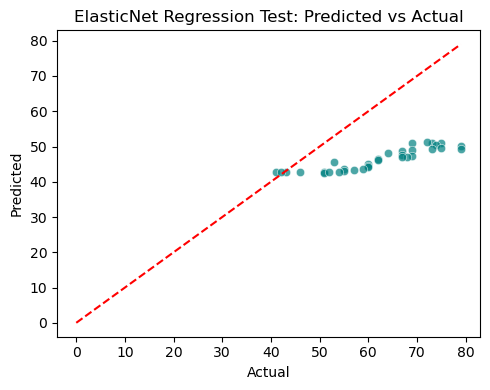

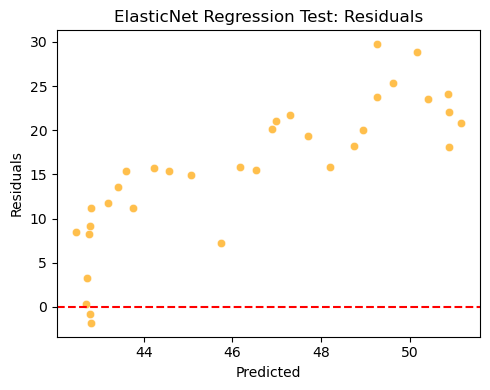

In [278]:
# --- Linear Regression (OLS) ---
linear_params = {
    "fit_intercept": [True, False],
    "positive": [False]  # safer for high-dimensional lag features
}

best_linear, metrics_train_linear, metrics_val_linear, metrics_test_linear, t_linear = run_full_regression_pipeline(
    LinearRegression(), linear_params,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="Linear Regression"
)

all_results["Linear"] = {
    "Train": metrics_train_linear,
    "Validation": metrics_val_linear,
    "Test": metrics_test_linear,
    "Train Time": t_linear
}

# --- Ridge Regression ---
ridge_params = {
    "alpha": [0.01, 0.1, 1, 10],
    "fit_intercept": [True, False],
    "positive": [True, False]
}

best_ridge, metrics_train_ridge, metrics_val_ridge, metrics_test_ridge, t_ridge = run_full_regression_pipeline(
    Ridge(), ridge_params,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="Ridge Regression"
)

all_results["Ridge"] = {
    "Train": metrics_train_ridge,
    "Validation": metrics_val_ridge,
    "Test": metrics_test_ridge,
    "Train Time": t_ridge
}

# --- Lasso Regression ---
lasso_params = {
    "alpha": [0.01, 0.1, 1, 10],
    "fit_intercept": [True, False],
    "positive": [True, False],
    "max_iter": [50000]  # ensure convergence
}

best_lasso, metrics_train_lasso, metrics_val_lasso, metrics_test_lasso, t_lasso = run_full_regression_pipeline(
    Lasso(), lasso_params,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="Lasso Regression"
)

all_results["Lasso"] = {
    "Train": metrics_train_lasso,
    "Validation": metrics_val_lasso,
    "Test": metrics_test_lasso,
    "Train Time": t_lasso
}

# --- ElasticNet Regression ---
elasticnet_params = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.3, 0.5, 0.7],
    "fit_intercept": [True, False],
    "positive": [False],  # safer for high-dimensional lag features
    "max_iter": [50000]
}

best_elastic, metrics_train_elastic, metrics_val_elastic, metrics_test_elastic, t_elastic = run_full_regression_pipeline(
    ElasticNet(), elasticnet_params,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="ElasticNet Regression"
)

all_results["ElasticNet"] = {
    "Train": metrics_train_elastic,
    "Validation": metrics_val_elastic,
    "Test": metrics_test_elastic,
    "Train Time": t_elastic
}


### 4.2 KNN Regression

=== KNN Regression ===
Fitting 3 folds for each of 168 candidates, totalling 504 fits
Best Parameters: {'leaf_size': 20, 'metric': 'chebyshev', 'n_neighbors': 36, 'weights': 'uniform'}
Training Time: 0.76 seconds
Training Metrics: {'MSE': 188.39782996054475, 'RMSE': 13.725808900044644, 'MAE': 10.636311569301261, 'R2': 0.5571441178986659}
Validation Metrics: {'MSE': 689.7669270833334, 'RMSE': 26.2634142312711, 'MAE': 24.647569444444443, 'R2': -5.539043598479238}
Test Metrics: {'MSE': 633.7724446259986, 'RMSE': 25.17483752928703, 'MAE': 22.030228758169933, 'R2': -4.742735336209931}


c:\Users\User\Downloads\scientific computing\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [-764.57460017 -764.34431656 -770.67192761 -769.78321474 -781.15293561
 -792.19243154 -761.28840634 -773.86745083 -698.14953055 -669.17628635
 -697.43846645 -661.32043949           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan -764.57460017 -764.34431656
 -770.67192761 -769.78321474 -781.15293561 -792.19243154 -761.28840634
 -773.86745083 -698.14953055 -669.17628635 -697.43846645 -661.32043949
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan -764.57460017 -764.34431656 -770.6719276

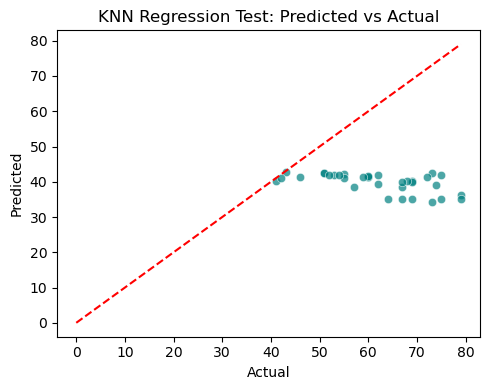

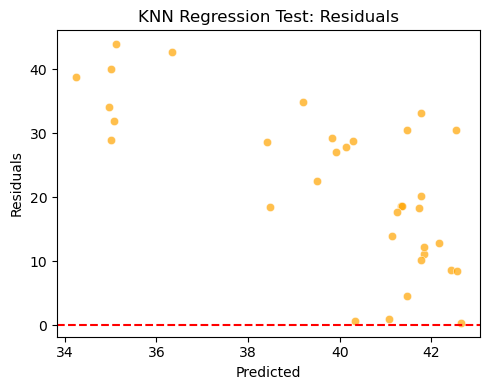

In [ ]:
# --- KNN Regression ---
knn_params = [
    # For Minkowski (with p)
    {
        "n_neighbors": [3, 36, 63, 81, 120, 140, 160],        # Number of neighbors
        "weights": ["uniform", "distance"],     # Uniform or distance-based weighting
        "metric": ["minkowski"],                # Use Minkowski distance
        "p": [1, 2],                            # Power parameter: 1=Manhattan, 2=Euclidean
        "leaf_size": [20, 30, 40]               # Leaf size for tree-based algorithms
    },
    # manhattan and chebyshev
    {
        "n_neighbors": [3, 36, 63, 81, 120, 140, 160],        # Number of neighbors
        "weights": ["uniform", "distance"],
        "metric": ["manhattan","chebyshev"],
        "leaf_size": [20, 30, 40]
    }
]


best_knn, metrics_train_knn, metrics_val_knn, metrics_test_knn, t_knn = run_full_regression_pipeline(
    KNeighborsRegressor(),
    knn_params,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    model_name="KNN Regression"
)

all_results["KNN"] = {
    "Train": metrics_train_knn,
    "Validation": metrics_val_knn,
    "Test": metrics_test_knn,
    "Train Time": t_knn
}


### 4.3 Decision Tree Regression

=== Decision Tree Regression ===
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Time: 0.53 seconds
Training Metrics: {'MSE': 4.2108419243986255, 'RMSE': 2.052033607034404, 'MAE': 1.531512027491409, 'R2': 0.9901018174402042}
Validation Metrics: {'MSE': 311.5625, 'RMSE': 17.651133108103853, 'MAE': 14.625, 'R2': -1.9536364982965488}
Test Metrics: {'MSE': 192.52941176470588, 'RMSE': 13.875496811455289, 'MAE': 11.588235294117647, 'R2': -0.7445464307829783}


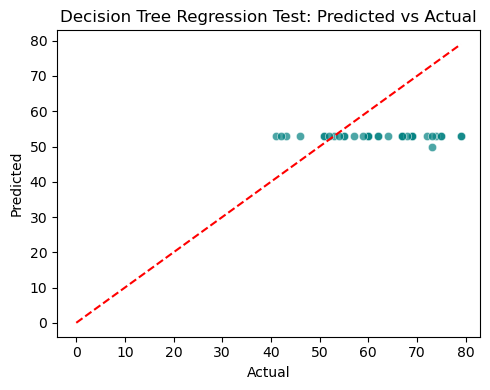

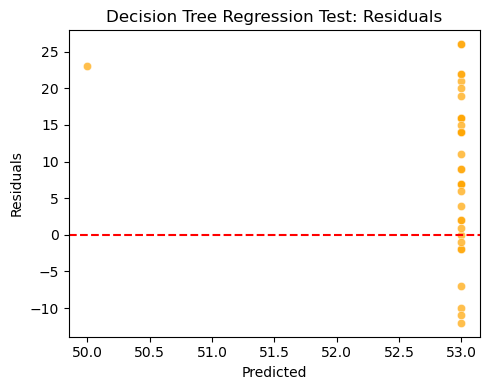

In [280]:
# --- Decision Tree Regression (expanded hyperparameters) ---
dt_params = {
    "max_depth": [3, 5, 7, None],           # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],        # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],          # Minimum samples in a leaf node
    "max_features": [None, "sqrt", "log2"]  # Maximum features considered for splits
}

best_dt, metrics_train_dt, metrics_val_dt, metrics_test_dt, t_dt = run_full_regression_pipeline(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    model_name="Decision Tree Regression"
)

all_results["DecisionTree"] = {
    "Train": metrics_train_dt,
    "Validation": metrics_val_dt,
    "Test": metrics_test_dt,
    "Train Time": t_dt
}


### 4.4 Summary of Results

In [281]:
# --- Summary Table of All Models ---
summary_rows = []
for name, result in all_results.items():
    row = {
        "Model": name,
        "Train Time (s)": result["Train Time"],
        # MSE
        "Train MSE": result["Train"]["MSE"],
        "Validation MSE": result["Validation"]["MSE"],
        "Test MSE": result["Test"]["MSE"],
        # RMSE
        "Train RMSE": result["Train"]["RMSE"],
        "Validation RMSE": result["Validation"]["RMSE"],
        "Test RMSE": result["Test"]["RMSE"],
        # MAE
        "Train MAE": result["Train"]["MAE"],
        "Validation MAE": result["Validation"]["MAE"],
        "Test MAE": result["Test"]["MAE"],
        # R²
        "Train R²": result["Train"]["R2"],
        "Validation R²": result["Validation"]["R2"],
        "Test R²": result["Test"]["R2"],
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

# Display summary table
summary_df.T


,0,1,2,3,4,5
Model,Linear,Ridge,Lasso,ElasticNet,KNN,DecisionTree
Train Time (s),0.034807,0.125306,0.735169,3.363311,0.760553,0.528996
Train MSE,0.0,15.436809,50.737992,161.313623,188.39783,4.210842
Validation MSE,146.344548,106.658729,113.587848,313.057702,689.766927,311.5625
Test MSE,304.669026,142.457735,131.240662,302.815503,633.772445,192.529412
Train RMSE,0.0,3.92897,7.123061,12.70093,13.725809,2.052034
Validation RMSE,12.097295,10.327571,10.65776,17.693437,26.263414,17.651133
Test RMSE,17.454771,11.935566,11.456032,17.401595,25.174838,13.875497
Train MAE,0.0,2.791849,5.667358,10.35766,10.636312,1.531512
Validation MAE,9.854957,8.781979,8.552666,14.818041,24.647569,14.625
